In [1]:
import SimpleITK as sitk
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import glob

In [2]:
itk_image = sitk.ReadImage('dataset/seg-lungs-LUNA16/1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222365663678666836860.mhd')
image_array = sitk.GetArrayViewFromImage(itk_image)

# print the image's dimensions
print(image_array.shape)

# # plot the image
# plt.imshow(image_array, cmap='gray')
# plt.show()

(194, 512, 512)


*.mhd files are used in Elastix and the ITK software packages. These files can be opened using the SimpleITK package, which is a rather schizophrenic translation of ITK to Python. The functions in this package do not adhere to Python conventions. *.mhd files themselves are pure text header files that contain properties of the images. For example, for the 1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222365663678666836860.mhd.mhd file, the parameters read

In [3]:
print(itk_image)

Image (000002074FAEA9E0)
  RTTI typeinfo:   class itk::Image<short,3>
  Reference Count: 1
  Modified Time: 1902
  Debug: Off
  Object Name: 
  Observers: 
    none
  Source: (none)
  Source output name: (none)
  Release Data: Off
  Data Released: False
  Global Release Data: Off
  PipelineMTime: 1872
  UpdateMTime: 1898
  RealTimeStamp: 0 seconds 
  LargestPossibleRegion: 
    Dimension: 3
    Index: [0, 0, 0]
    Size: [512, 512, 194]
  BufferedRegion: 
    Dimension: 3
    Index: [0, 0, 0]
    Size: [512, 512, 194]
  RequestedRegion: 
    Dimension: 3
    Index: [0, 0, 0]
    Size: [512, 512, 194]
  Spacing: [0.644531, 0.644531, 1.8]
  Origin: [-157.678, -311.678, -438.4]
  Direction: 
1 0 0
0 1 0
0 0 1

  IndexToPointMatrix: 
0.644531 0 0
0 0.644531 0
0 0 1.8

  PointToIndexMatrix: 
1.55152 0 0
0 1.55152 0
0 0 0.555556

  Inverse Direction: 
1 0 0
0 1 0
0 0 1

  PixelContainer: 
    ImportImageContainer (000002074ED6DEE0)
      RTTI typeinfo:   class itk::ImportImageContainer<unsig

This shows that this Lung is a 3D image, consisting of shape 512,512,194 with 0.644531mm x 0.644531mm x 1.8 mm pixels (ElementSpacing) and a size of 512 by 512. The MET_DOUBLE type will be converted to the numpy.float64 dtype.

In [4]:
#Number of dimention
itk_image.GetDimension()

3

In [5]:
#size of the data
itk_image.GetSize()

(512, 512, 194)

In [6]:
#CenterOfRotation
itk_image.GetOrigin()

(-157.67773, -311.67773, -438.4)

In [7]:
#ElementSpacing
itk_image.GetSpacing()

(0.64453125, 0.64453125, 1.7999999523162842)

In [8]:
#TransformMatrix
itk_image.GetDirection()

(1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0)

In [9]:
class ct_scan_processing(object):
    """
    Class that manipulates and processes over images in the dataset using SimpleITK tools and PIL library.
    Is responsible for:
    1. Read the image from specified filename
    2. Convert the image into it's array representation,
    3. Get coordinates corresponding to origin, voxel,
    4. Reset the coordinates of the original image,
    5. Normalizes the image, 
    6. Writing the modified image back to the file.
    
    """
    def __init__(self, filename = None, coords = None, path = None):
        """
        Constructor to initialize file name, coordinates, image array and PIL image object.
        
        """
        self.filename = filename
        self.coords = coords
        self.ds = None
        self.image = None
        self.file_storage_location = path

    def set_coords(self, coords):
        self.coords = coords

    def read_mhd_image(self):
        file_storage_location = glob.glob('dataset/seg-lungs-LUNA16/'+self.filename+'*.mhd', recursive =True)
        # Reads the image using SimpleITK
        self.ds = sitk.ReadImage(file_storage_location[0])
        #print(self.ds)
         # Convert the image to a  numpy array
        self.image = sitk.GetArrayFromImage(self.ds)

    def get_resolution(self):
        return self.ds.GetSpacing()

    def get_origin(self):
        return self.ds.GetOrigin()

    def get_ds(self):
        return self.ds
    def get_voxel_coords(self):
        origin = self.get_origin()
        resolution = self.get_resolution()
        voxel_coords = [np.absolute(self.coords[j]-origin[j])/resolution[j] \
            for j in range(len(self.coords))]
        return tuple(voxel_coords)
    
    def get_image(self):
        return self.image
    
    def get_subimage(self, width):
        self.read_mhd_image()
        x, y, z = self.get_voxel_coords()
        subImage = self.image[int(z), int(y-width/2):int(y+width/2), int(x-width/2):int(x+width/2)]
        return subImage   
    
    def normalizePlanes(self, npzarray):
        """
        Normalizing the image using the appropriate maximum and minimum values associated 
        with a CT scan for lung cancer (in terms of Hounsfeld Units)
        
        """
        max_hu = 200.
        min_hu= -1000.
        npzarray = (npzarray - min_hu) / (max_hu - min_hu)
        npzarray[npzarray>1] = 1.
        npzarray[npzarray<0] = 0.
        return npzarray
    
    def save_image(self, filename, width):
        """
        Converts the normalized cropped image into a grayscale image and store in
        the filename argument specified location.
        
        """
        image = self.get_subimage(width)
        image = self.normalizePlanes(image)
        Image.fromarray(image*255).convert('L').save(filename)

In [10]:
candidates =pd.read_csv("dataset/candidates_V2/candidates_V2.csv")

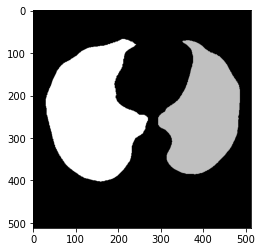

In [11]:
scan = ct_scan_processing(np.asarray(candidates.iloc[0])[0], \
              np.asarray(candidates.iloc[0])[1:-1])
scan.read_mhd_image()
image = scan.get_subimage(10000)
plt.figure()
plt.imshow(image, cmap = 'gray')

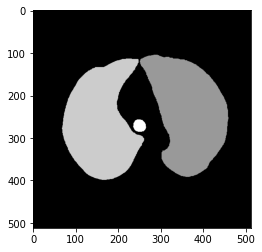

In [15]:
scan = ct_scan_processing(np.asarray(candidates.iloc[438])[0], \
              np.asarray(candidates.iloc[438])[1:-1])
scan.read_mhd_image()
image = scan.get_subimage(10000)
plt.figure()
plt.imshow(image, cmap = 'gray')

1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222365663678666836860


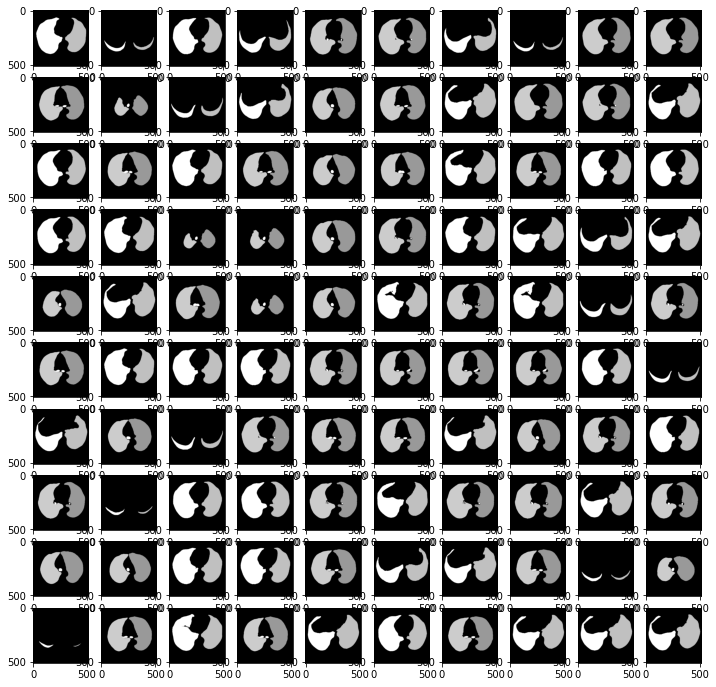

In [28]:
import numpy as np
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(12, 12))
columns = 10
rows = 10
for i in range(1, columns*rows +1):
    scan = ct_scan_processing(np.asarray(candidates.iloc[i-1])[0], \
              np.asarray(candidates.iloc[i-1])[1:-1])
    scan.read_mhd_image()
    image = scan.get_subimage(2000)
    img = image
    fig.add_subplot(rows, columns, i)
    plt.imshow(image, cmap = 'gray')
print(candidates.iloc[i][0])
plt.show()

1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222365663678666836860


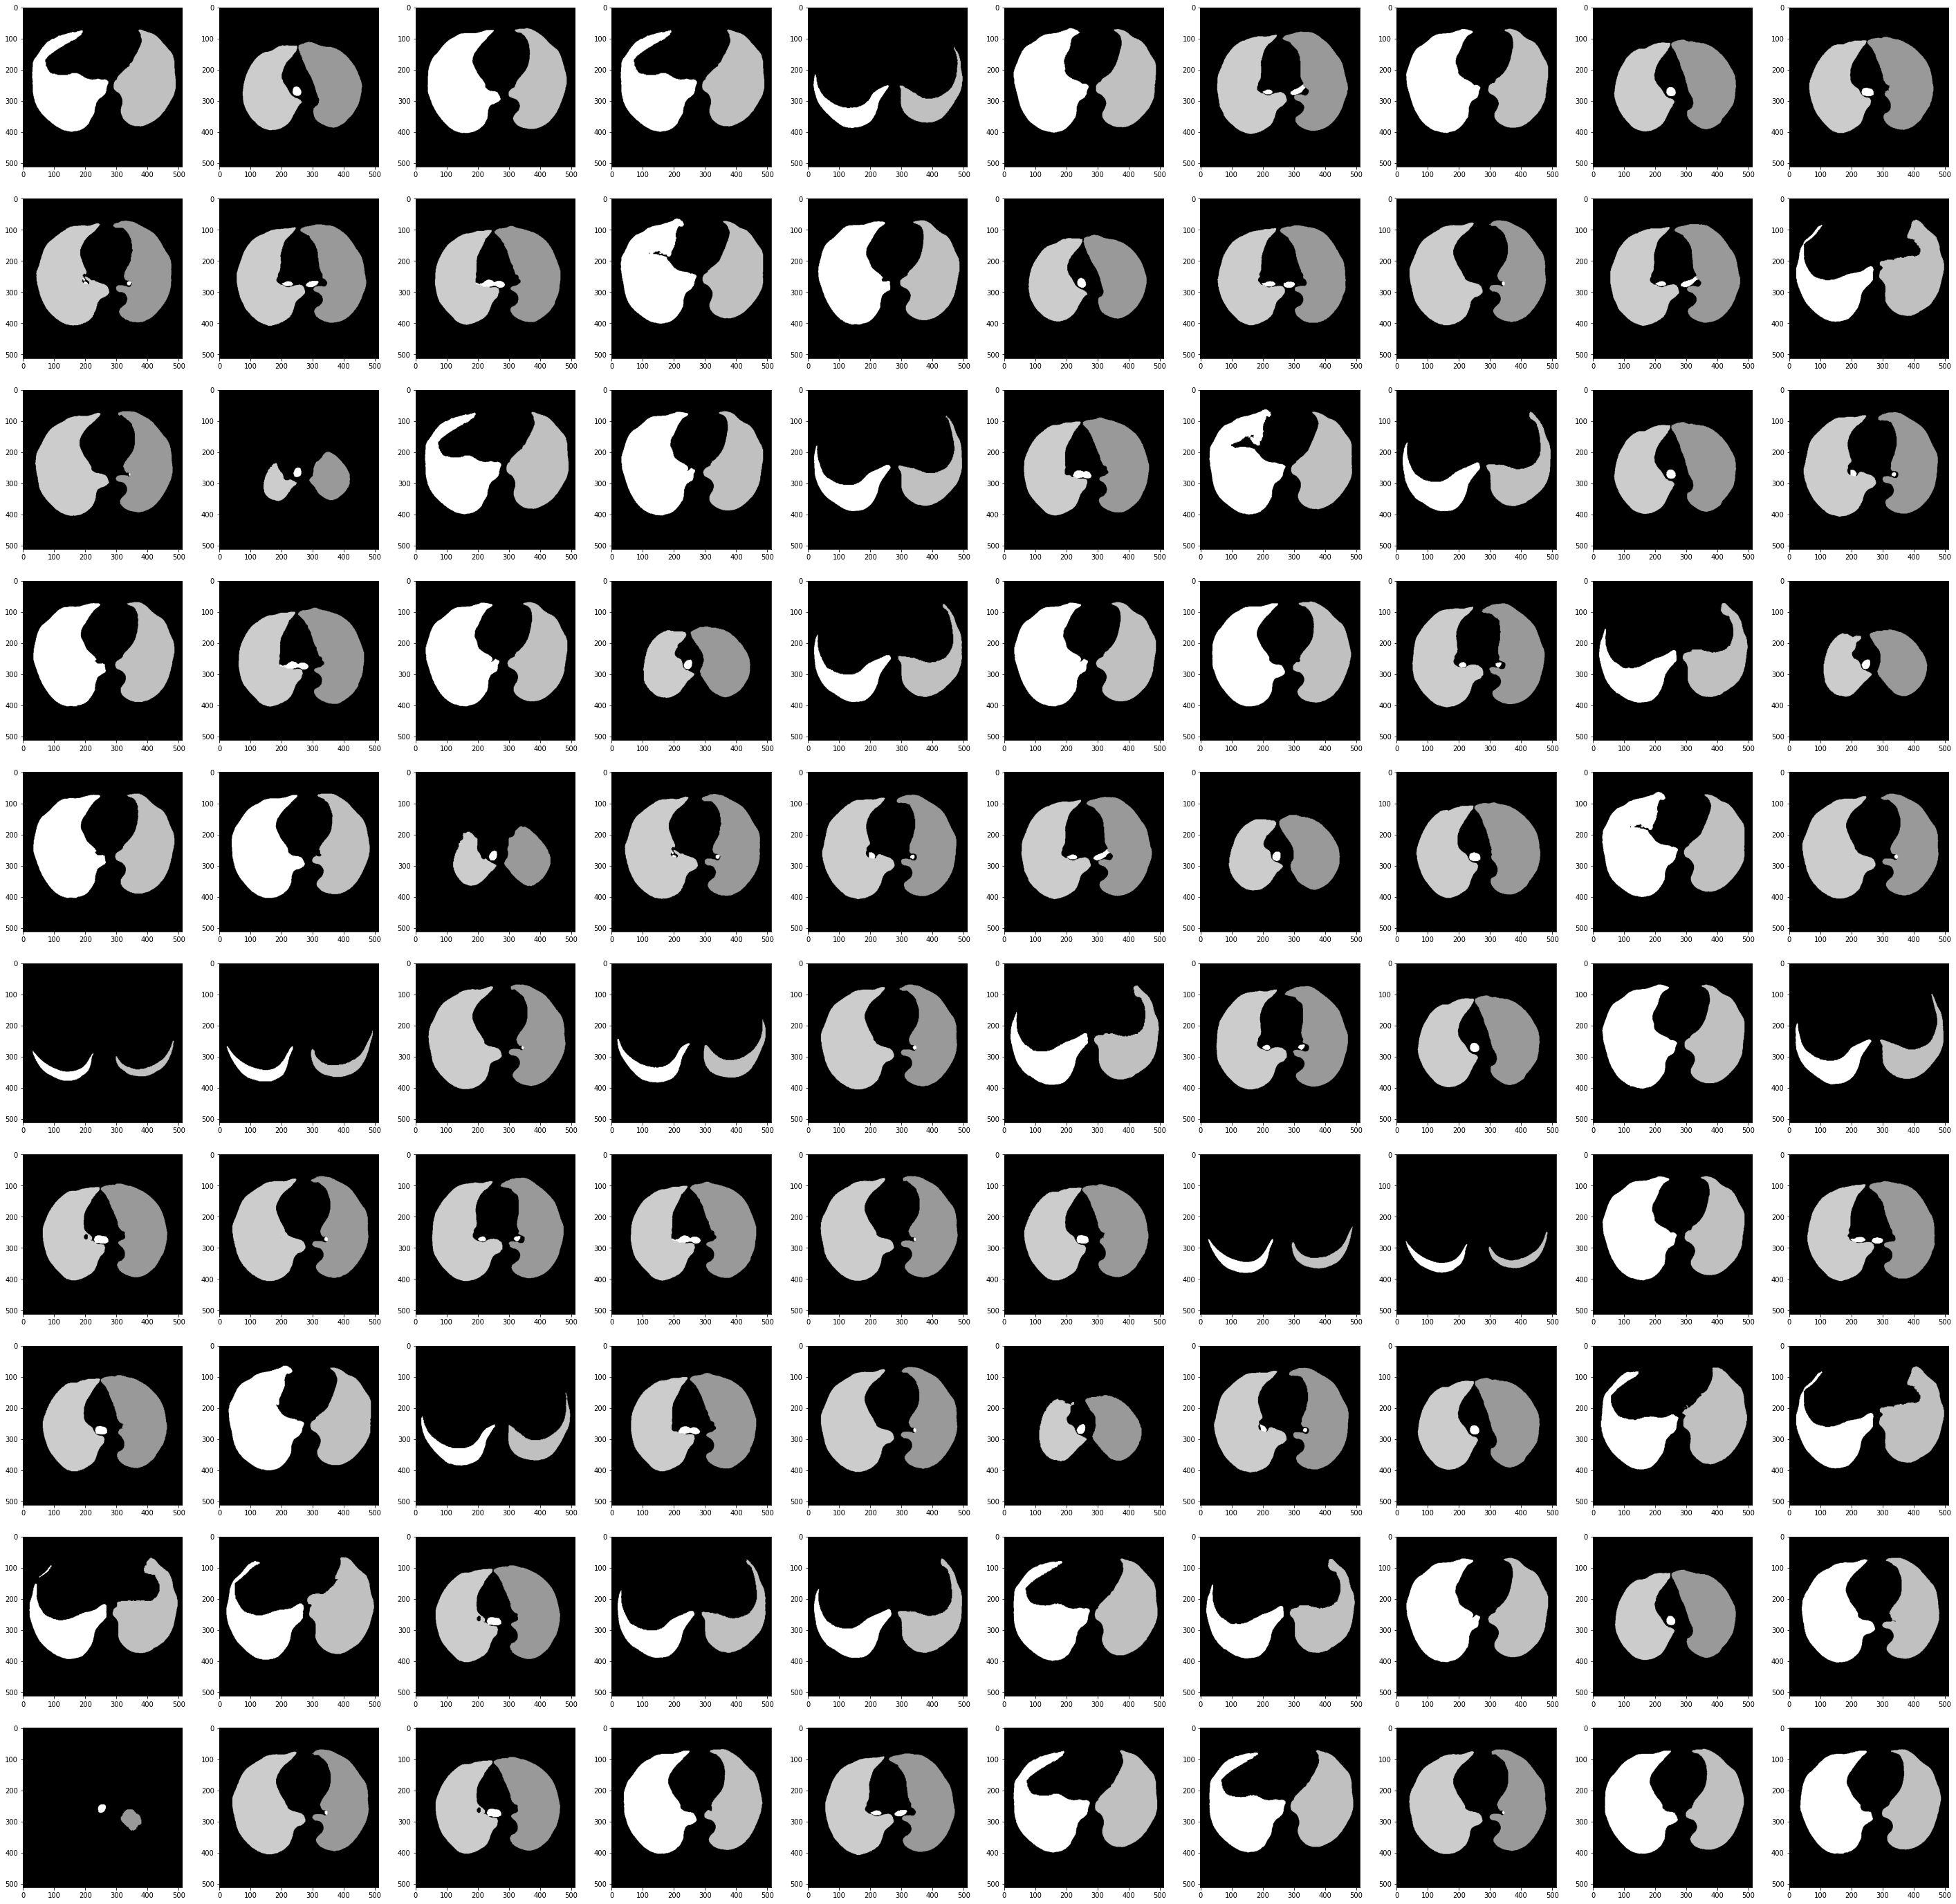

In [29]:
fig = plt.figure(figsize=(50, 50))
columns = 10
rows = 10
for i in range(1, columns*rows +1):
    scan = ct_scan_processing(np.asarray(candidates.iloc[430 + i-1])[0], \
              np.asarray(candidates.iloc[430 + i-1])[1:-1])
    scan.read_mhd_image()
    image = scan.get_subimage(2000)
    img = image
    fig.add_subplot(rows, columns, i)
    plt.imshow(image, cmap = 'gray')
print(candidates.iloc[i][0])
plt.show()